In [2]:
import numpy as np
import cv2
import pandas as pd
from imutils import paths
import os
from PIL import Image
from sklearn.preprocessing import LabelBinarizer

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# import zipfile
# import os

In [5]:
# zip_file_path='/content/drive/MyDrive/archive.zip'

In [6]:
# extracted='/content/drive/MyDrive/extracted'

In [7]:
# with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
#   zip_ref.extractall(extracted)

In [5]:
tom_dir=r'C:\Users\Atharva\Desktop\SIH\archive\PlantVillage\Tomato'

In [6]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
    return image_paths,labels

In [7]:
df = pd.DataFrame()
df['image'], df['label'] = createdataframe(tom_dir)

In [8]:
df.head()

,image,label
0,C:\Users\Atharva\Desktop\SIH\archive\PlantVill...,Tomato_Bacterial_spot
1,C:\Users\Atharva\Desktop\SIH\archive\PlantVill...,Tomato_Bacterial_spot
2,C:\Users\Atharva\Desktop\SIH\archive\PlantVill...,Tomato_Bacterial_spot
3,C:\Users\Atharva\Desktop\SIH\archive\PlantVill...,Tomato_Bacterial_spot
4,C:\Users\Atharva\Desktop\SIH\archive\PlantVill...,Tomato_Bacterial_spot


In [9]:
df.shape

(16012, 2)

In [10]:
df.columns

Index(['image', 'label'], dtype='object')

In [11]:
df.nunique()

image    16012
label       10
dtype: int64

In [12]:
df['label'].value_counts()

label
Tomato__Tomato_YellowLeaf__Curl_Virus          3209
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1591
Tomato__Target_Spot                            1404
Tomato_Early_blight                            1000
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Name: count, dtype: int64

In [13]:
df.isnull().sum()

image    0
label    0
dtype: int64

# PreProcessing

In [14]:
def check_image_paths(df, column_name='image'):
    # Check if the path exists for each row in the 'image' column
    df['path_exists'] = df[column_name].apply(lambda x: os.path.exists(x))

    # Get rows where the path doesn't exist
    missing_images = df[~df['path_exists']]

    if not missing_images.empty:
        print("Some image paths are incorrect or the images are missing.")
        print(missing_images[[column_name]])
    else:
        print("All image paths are correct and accessible.")

# Example usage
check_image_paths(df, column_name='image')

All image paths are correct and accessible.


In [15]:
def preprocess_image(image_path, img_size):
    # Load the image from the file, resize it to the target size, and normalize pixel values
    image_list=[]
    for i, images in enumerate(image_path):
        image = cv2.imread(images)
        if image is None:
            print(f"Image at index {i} with path '{image_path}' could not be loaded.")
            continue

        image = cv2.resize(image, img_size)
        image = image.astype('float32') / 255.0
        image_list.append(image)
    image_list=np.array(image_list)
    print(image_list.shape)
    return image_list

In [16]:
img_size = (150, 150)
X = preprocess_image(df['image'],img_size)

Image at index 16011 with path '0        C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
1        C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
2        C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
3        C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
4        C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
                               ...                        
16007    C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
16008    C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
16009    C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
16010    C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
16011    C:\Users\Atharva\Desktop\SIH\archive\PlantVill...
Name: image, Length: 16012, dtype: object' could not be loaded.
(16011, 150, 150, 3)


In [17]:
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(df['label'])

In [18]:
y.shape

(16012, 10)

In [19]:
y = np.delete(y, 14047, axis=0)
print(y.shape)

(16011, 10)


In [18]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Self made CNN

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_binarizer.classes_), activation='softmax')  # Number of classes
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Atharva\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32
)

Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 327s 913ms/step - accuracy: 0.4547 - loss: 1.5708
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 311s 886ms/step - accuracy: 0.8208 - loss: 0.5384
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 323s 918ms/step - accuracy: 0.8650 - loss: 0.3928
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 305s 869ms/step - accuracy: 0.8964 - loss: 0.3124
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 300s 854ms/step - accuracy: 0.9260 - loss: 0.2236
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 306s 870ms/step - accuracy: 0.9503 - loss: 0.1508
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 310s 881ms/step - accuracy: 0.9566 - loss: 0.1284
Epoch 8/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 316s 899ms/step - accuracy: 0.9539 - loss: 0.1343
Epoch 9/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 313s 893ms/step - accuracy: 0.9744 - loss: 0.0808
Epoch 10/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 303s 862ms/step - accuracy: 0.9694 - loss: 0.0955
Epoch 11/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 298s 848ms/step - accuracy: 0.9823 - loss: 0.0577
Epoch 12

In [22]:
test_loss, test_acc = model.evaluate(X_temp, y_temp)
print(f"Test Accuracy: {test_acc}")

151/151 ━━━━━━━━━━━━━━━━━━━━ 24s 156ms/step - accuracy: 0.9173 - loss: 0.3978
Test Accuracy: 0.9236053228378296


In [23]:
model.save('plant_disease_model.h5')

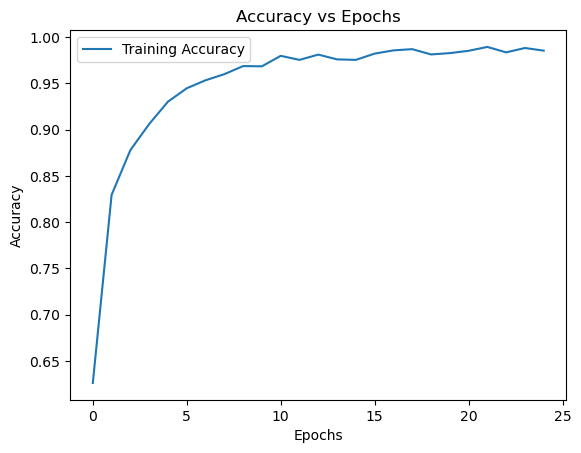

In [59]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
def preprocess_image_predict(image_path, img_size):
    # Load the image from the file, resize it to the target size, and normalize pixel values
    image_list=[]
    
    image = cv2.imread(image_path)
        
    image = cv2.resize(image, img_size)
    image = image.astype('float32') / 255.0
    image_list.append(image)
    image_list=np.array(image_list)
    print(image_list.shape)
    return image_list

In [50]:
img_path= r'C:\Users\Atharva\Desktop\SIH\archive\PlantVillage\Tomato\Tomato_healthy\fe8f8808-2631-491e-a46b-bd2a1a4958e7___GH_HL Leaf 213.1.JPG'

In [51]:
img_size=(150, 150)
img_array=preprocess_image_predict(img_path,img_size)

(1, 150, 150, 3)


In [52]:
img_array=np.array(img_array)

In [53]:
img_array.shape

(1, 150, 150, 3)

In [54]:
predictions=model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


In [55]:
predicted_class=np.argmax(predictions, axis=1)

In [56]:
class_labels=list(label_binarizer.classes_)  # Assuming you used a label_binarizer
predicted_label=class_labels[predicted_class[0]]
predicted_label

'Tomato_healthy'

In [ ]:
image = cv2.imread(img_path)

In [ ]:
plt.imshow(image)
plt.title(f"Disease Name":{predicted_label})


# pre trained VGG16

In [60]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [61]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [62]:
for layer in base_model.layers:
    layer.trainable = False

In [64]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_binarizer.classes_), activation='softmax')(x)

In [65]:
model1 = Model(inputs=base_model.input, outputs=predictions)

In [66]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
history1 = model1.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64
)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 814s 5s/step - accuracy: 0.6478 - loss: 1.0859
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 788s 4s/step - accuracy: 0.8041 - loss: 0.5927
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 794s 5s/step - accuracy: 0.8364 - loss: 0.4772
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 779s 4s/step - accuracy: 0.8548 - loss: 0.4148
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 791s 4s/step - accuracy: 0.8735 - loss: 0.3673
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 672s 4s/step - accuracy: 0.8961 - loss: 0.2993
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.9010 - loss: 0.2896
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.8952 - loss: 0.2919
Epoch 9/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.9128 - loss: 0.2455
Epoch 10/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.9220 - loss: 0.2292


In [70]:
test_loss, test_acc = model1.evaluate(X_temp, y_temp)
print(f"Test Accuracy: {test_acc}")



151/151 ━━━━━━━━━━━━━━━━━━━━ 146s 946ms/step - accuracy: 0.8893 - loss: 0.3194
Test Accuracy: 0.8955037593841553


In [71]:
model1.save('plant_disease_model_preTrained.h5')